<a href="https://colab.research.google.com/github/sugam11/rag-multimodal-qa/blob/main/Multimodal_Retriever.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

**Retrieval Augmented Generation (RAG)** utilizes context to solve the problem of **hallucination** and **lack of easy updates** in Large Language Models (LLM). When trained end-to-end, this approach can also help **reduce the model size** since the models no longer have to memorize content to generate their output. However, most RAG approaches utilize only text to provide context, neglecting the ubiquitous amount of knowledge in other modalities like images – much of which contains information not covered by any text. In this blog, I will share a tutorial on how to build a multimodal (image + text) retrieval using NumPy arrays and HuggingFace models!

**If you don't want to look at the code, and just want to test the functionality, feel free to run all the cells and skip to the testing part of the notebook!**

# Installing Dependencies

In [ ]:
!pip install transformers
!pip install sentence-transformers
!pip install tqdm

# High-Level Design
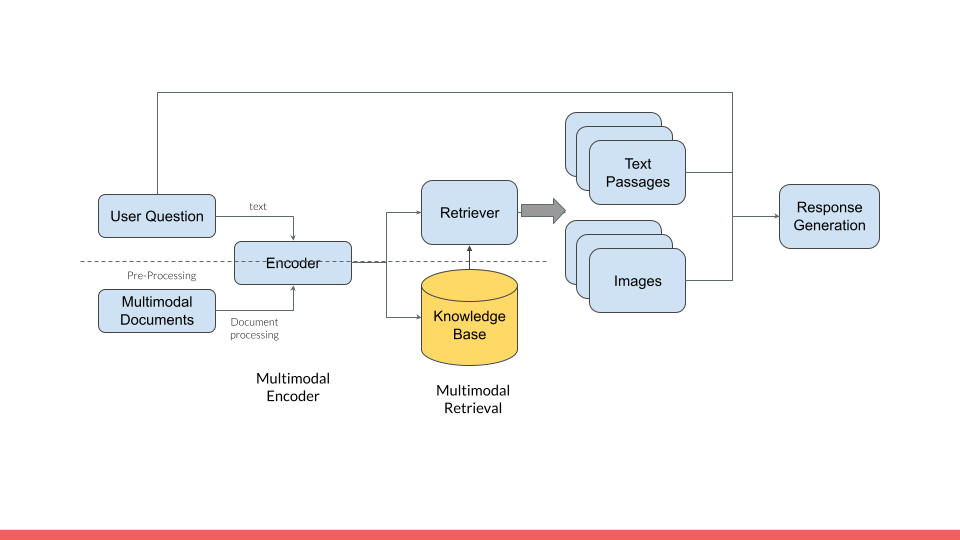

Most RAG approaches follow the design flow in the above diagram. A RAG system has 3 major components -

**Embeddings** : We must encode images/text in a vector space for retrieval. So, we need a model that can generate a vector for images and text. These embeddings must be trained so that semantically similar image-text and text-text pairs appear closer in the vector space. Please note there are other methods to do this, but I am not covering that in this tutorial.

**Retriever** : We need a mechanism to store the embeddings of the images and text documents and retrieve them for a user question. *While there are efficient Approximate Nearest Neighbor (ANN) based libraries like FAISS, I am using simply Numpy arrays for this tutorial. As it turns out, you only need ANN if your document set is greater than 1M.*

**Generator** : This component, usually an LLM, considers the user question and the context retrieved to generate the final output. Appending the context helps address the hallucination and update issue mentioned in the introduction. Since we are retrieving multimodal documents, we need a model that can consider multimodal input to generate its final output.

In this tutorial, I will not talk about the generator part but focus on the embeddings and the retriever part.

# Embedder
While multimodal models like CLIP/BLIP can encode both text and images in the same vector space, I found that there are better models for text-text retrieval. Thus, in this tutorial, I will share two methods to encode and retrieve images and text - single encoder (CLIP) and hybrid (CLIP for image, SBert model for text).

The following code block uses the CLIP model and has methods to compute text and image embeddings. The CLIP model returns a vector of size 512, which we will later store in a NumPy array.

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
import torch
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer

class CLIPEmbedder:
    def __init__(self, model_ID, device):
        # Save the model to device
        self.model = CLIPModel.from_pretrained(model_ID).to(device)
        # Get the processor
        self.processor = CLIPProcessor.from_pretrained(model_ID)
        # Get the tokenizer
        self.tokenizer = CLIPTokenizer.from_pretrained(model_ID)
        self.pretty_name = "CLIP"
        self.device = device

    def get_name (self,):
        return self.pretty_name

    def get_text_embedding(self, text):
        inputs = self.tokenizer(text, return_tensors="pt", truncation=True).to(self.device)
        text_embeddings = self.model.get_text_features(**inputs)
        # convert the embeddings to numpy array
        embedding_as_np = text_embeddings.cpu().detach().numpy()
        return embedding_as_np

    def get_img_embedding(self, img):
        image = self.processor(text=None, images=img, return_tensors="pt")[
            "pixel_values"
        ].to(self.device)
        embedding = self.model.get_image_features(image)
        # convert the embeddings to numpy array
        embedding_as_np = embedding.cpu().detach().numpy()
        return embedding_as_np

clip_embedder = CLIPEmbedder("openai/clip-vit-base-patch32", device)

The following code block uses CLIP and an SBert model for a hybrid document search. We use the CLIP model to encode images and the SBert model to encode text.

In [5]:
import torch
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer
from sentence_transformers import SentenceTransformer, util

class HybridEmbedder:
    def __init__(self, model_ID, device):
        # Save the model to device
        self.image_model = CLIPModel.from_pretrained(model_ID).to(device)
        # Get the processor
        self.image_processor = CLIPProcessor.from_pretrained(model_ID)
        # Get the tokenizer
        self.image_tokenizer = CLIPTokenizer.from_pretrained(model_ID)
        self.text_embedder = SentenceTransformer("all-mpnet-base-v2")
        self.pretty_name = "HYBRID"
        self.device = device

    def get_name (self,):
        return self.pretty_name

    def get_text_embedding(self, text, emb_type="text"):
        if emb_type == "text":
            text_embeddings = self.text_embedder.encode(text, convert_to_tensor=True)
        else:
            inputs = self.image_tokenizer(text, return_tensors="pt", truncation=True).to(self.device)
            text_embeddings = self.image_model.get_text_features(**inputs)
        embedding_as_np = text_embeddings.cpu().detach().numpy()
        return embedding_as_np

    def get_img_embedding(self, img):
        image = self.image_processor(text=None, images=img, return_tensors="pt")[
            "pixel_values"
        ].to(self.device)
        embedding = self.image_model.get_image_features(image)
        # convert the embeddings to a numpy array
        embedding_as_np = embedding.cpu().detach().numpy()
        return embedding_as_np

hybrid_embedder = HybridEmbedder("openai/clip-vit-base-patch32", device)

# Retriever

Now that we have a way to compute embedding for both text and images, we need to design a retriever that can do the following -

1. **Compute** the embeddings for all documents.

2. **Store** these embeddings and the documents.

3. **Retrieve** documents relevant to the user query.

We define a class NumpySearch that contains these 3 functionalities -

In [36]:
import numpy as np
import os
import pickle
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm


STORE = "/content/db/"

class NumpySearch():
    def __init__(self, embedder, dataset):
        self.embedder = embedder
        self.meta_data = {}
        self.vectors = []
        self.idx = 0
        self.store_path = os.path.join(STORE, embedder.get_name())
        # If vector store already exists, load it
        if os.path.exists(STORE):
            if os.path.exists(self.store_path):
                if os.path.exists(os.path.join(self.store_path, f"vectors_{dataset}.npy")):
                    self.vectors = np.load(os.path.join(self.store_path, f"vectors_{dataset}.npy"))
                    print(f"loaded {self.vectors.shape[0]} vectors")
                if os.path.exists(os.path.join(self.store_path, f"meta_data_{dataset}.pkl")):
                    with open(
                        os.path.join(self.store_path, f"meta_data_{dataset}.pkl"), "rb"
                    ) as handle:
                        self.meta_data = pickle.load(handle)
                        print("Loaded metadata from pickle file")

        # Compute vectors and store them if vector store doesn't exist
        if len(self.meta_data.keys()) == 0 or len(self.vectors) == 0:
            self.process_documents(dataset)
        self.vectors = self.vectors.reshape(-1, 512)


The above block of code initializes the class NumpySearch. It requires two arguments - **embedder** and **dataset**. We use the embedder discussed previously here, and the dataset can be any generic dataset that implements the following methods - `get_all_texts()` and `get_all_images()`. The `get_all_texts()` method should return a JSON with a "text" field containing the document's text to be stored. The `get_all_images()` method should return a JSON with an "image" field containing an image opened using the Pillow library.

Finally, we can add the second method to the NumpySearch class - compute embeddings and store them.

In [7]:
# Add this method to the NumpySearch class

def process_documents(self, data_set):
# Compute embeddings for text and images
        for text in tqdm(data_set.get_all_texts()):
            embed = self.embedder.get_text_embedding(text["text"])
            self.vectors.append(embed)
            text["type"] = "text"
            self.meta_data[self.idx] = text
            self.idx += 1
        for img in tqdm(data_set.get_all_images()):
            image_id = img["path"]
            try:
                image = data_set.get_image(image_id)
                self.vectors.append(embed)
                img["type"] = "img"
                self.meta_data[self.idx] = img
                self.idx += 1
            except Exception as e:
                print(e)
                print(img)
# Stack both text and image vectors together
        self.vectors = np.stack(self.vectors)
# Storing embeddings and document metadata
        if not os.path.exists(STORE):
            os.mkdir(STORE)
        if not os.path.exists(self.store_path):
            os.mkdir(self.store_path)
        np.save(os.path.join(self.store_path, f"vectors_{data_set}.npy"), self.vectors)
        with open(os.path.join(self.store_path, f"meta_data_{data_set}.pkl"), "wb") as handle:
            pickle.dump(self.meta_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

Now, we have written a simple logic to compute embeddings for the text and image data and store them in pickle files for loading them in the future. Finally, we can finish the NumpySearch class with the last functionality - retrieve documents given a user question.

In [9]:
# Add this method to the NumpySearch class

def retrieve(self, text, result_type="hybrid", k=5):
        embed = self.embedder.get_text_embedding(text)
        distance_matrix = cosine_similarity(embed.reshape(1, -1), self.vectors)
        distances = distance_matrix[0]
        top_k_idx = np.argsort(distances)[::-1]
        if result_type == "hybrid":
            top_k_docs = [self.meta_data[idx] for idx in top_k_idx[:k]]
        elif result_type == "text":
            top_k_docs = [
                self.meta_data[idx]
                for idx in top_k_idx[:2*k]
                if self.meta_data[idx]["type"] == "text"
            ][:k]
        else:
            top_k_docs = [
                self.meta_data[idx]
                for idx in top_k_idx[:100 * k]
                if self.meta_data[idx]["type"] == "img"
            ][:k]
        return top_k_docs

Overall, our final class looks something like this.

In [38]:
class NumpySearch():
    def __init__(self, embedder, data_set):
        self.embedder = embedder
        self.meta_data = {}
        self.vectors = []
        self.idx = 0
        self.store_path = os.path.join(STORE, embedder.get_name())
        if os.path.exists(STORE):
            if os.path.exists(self.store_path):
                if os.path.exists(os.path.join(self.store_path, f"vectors_{data_set}.npy")):
                    self.vectors = np.load(os.path.join(self.store_path, f"vectors_{data_set}.npy"))
                    print(f"loaded {self.vectors.shape[0]} vectors")
                if os.path.exists(os.path.join(self.store_path, f"meta_data_{data_set}.pkl")):
                    with open(
                        os.path.join(self.store_path, f"meta_data_{data_set}.pkl"), "rb"
                    ) as handle:
                        self.meta_data = pickle.load(handle)
                        print("Loaded meta data from pickle file")

        if len(self.meta_data.keys()) == 0 or len(self.vectors) == 0:
            self.process_documents(data_set)
        self.vectors = self.vectors.reshape(-1, 512)

    def process_documents(self, data_set):
        self.meta_data = {}
        self.vectors = []
        print(f"Computing Embeddings for: {data_set}")
        print(f"Computing text embeddings")
        for text in tqdm(data_set.get_all_texts()):
            embed = self.embedder.get_text_embedding(text["text"])
            self.vectors.append(embed)
            text["type"] = "text"
            self.meta_data[self.idx] = text
            self.idx += 1
        print(f"Computing image embeddings")
        for img in tqdm(data_set.get_all_images()):
            image_id = img["path"]
            try:
                image = data_set.get_image(image_id)
                self.vectors.append(embed)
                img["type"] = "img"
                self.meta_data[self.idx] = img
                self.idx += 1
            except Exception as e:
                print(e)
                print(img)
        self.vectors = np.stack(self.vectors)
        print(f"Storing embeddings")
        if not os.path.exists(STORE):
            os.mkdir(STORE)
        if not os.path.exists(self.store_path):
            os.mkdir(self.store_path)
        np.save(os.path.join(self.store_path, f"vectors_{data_set}.npy"), self.vectors)
        with open(os.path.join(self.store_path, f"meta_data_{data_set}.pkl"), "wb") as handle:
            pickle.dump(self.meta_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

    def retrieve(self, text, result_type="hybrid", k=5):
        embed = self.embedder.get_text_embedding(text)
        distance_matrix = cosine_similarity(embed.reshape(1, -1), self.vectors)
        distances = distance_matrix[0]
        top_k_idx = np.argsort(distances)[::-1]
        if result_type == "hybrid":
            top_k_docs = [self.meta_data[idx] for idx in top_k_idx[:k]]
        elif result_type == "text":
            top_k_docs = [
                self.meta_data[idx]
                for idx in top_k_idx[:2*k]
                if self.meta_data[idx]["type"] == "text"
            ][:k]
        else:
            top_k_docs = [
                self.meta_data[idx]
                for idx in top_k_idx[:100 * k]
                if self.meta_data[idx]["type"] == "img"
            ][:k]

        return top_k_docs

The above method takes the user question as text and outputs top_k relevant documents. The type of documents can be described using the "result_type" parameter.

You can find the hybrid version of this retriever below.

In [34]:
class HybridNumpySearch():
    def __init__(self, embedder, data_set):
        self.embedder = embedder
        self.meta_data = {}
        self.img_vectors = []
        self.text_vectors = []
        self.idx = 0
        self.text_idx = 0
        self.store_path = os.path.join(STORE, embedder.get_name())
        if os.path.exists(STORE):
            if os.path.exists(self.store_path):
                if os.path.exists(os.path.join(self.store_path, f"vectors_{data_set}_text.npy")):
                    self.text_vectors = np.load(os.path.join(self.store_path, f"vectors_{data_set}_text.npy"))
                    self.img_vectors = np.load(os.path.join(self.store_path, f"vectors_{data_set}_img.npy"))
                    print(f"loaded {self.text_vectors.shape[0]} vectors")
                    print(f"loaded {self.img_vectors.shape[0]} vectors")
                if os.path.exists(os.path.join(self.store_path, f"meta_data_{data_set}.pkl")):
                    with open(
                        os.path.join(self.store_path, f"meta_data_{data_set}.pkl"), "rb"
                    ) as handle:
                        self.meta_data = pickle.load(handle)
                        print("Loaded meta data from pickle file")

        if len(self.meta_data.keys()) == 0 or len(self.text_vectors) == 0 or len(self.img_vectors) == 0:
            self.process_documents(data_set)
        self.text_vectors = self.text_vectors.reshape(-1, 768)
        self.img_vectors = self.img_vectors.reshape(-1, 512)
        self.text_idx = self.text_vectors.shape[0]

    def process_documents(self, data_set):
        self.meta_data = {}
        self.img_vectors = []
        self.text_vectors = []
        print(f"Computing Embeddings for: {data_set}")
        print(f"Computing text embeddings")
        for text in tqdm(data_set.get_all_texts()):
            embed = self.embedder.get_text_embedding(text["text"])
            self.text_vectors.append(embed)
            text["type"] = "text"
            self.meta_data[self.idx] = text
            self.idx += 1
            self.text_idx += 1
        print(f"Computing image embeddings")
        for img in tqdm(data_set.get_all_images()):
            image_id = img["path"]
            try:
                image = data_set.get_image(image_id)
                self.img_vectors.append(embed)
                img["type"] = "img"
                self.meta_data[self.idx] = img
                self.idx += 1
            except Exception as e:
                print(e)
                print(img)
        self.text_vectors = np.stack(self.text_vectors)
        self.img_vectors = np.stack(self.img_vectors)
        print(f"Storing embeddings")
        if not os.path.exists(STORE):
            os.mkdir(STORE)
        if not os.path.exists(self.store_path):
            os.mkdir(self.store_path)
        np.save(os.path.join(self.store_path, f"vectors_{data_set}_text.npy"), self.text_vectors)
        np.save(os.path.join(self.store_path, f"vectors_{data_set}_img.npy"), self.img_vectors)
        with open(os.path.join(self.store_path, f"meta_data_{data_set}.pkl"), "wb") as handle:
            pickle.dump(self.meta_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

    def retrieve(self, text, result_type="text", k=5):
        embed = self.embedder.get_text_embedding(text)
        distance_matrix = cosine_similarity(embed.reshape(1, -1), self.text_vectors)
        distances = distance_matrix[0]
        top_k_idx = np.argsort(distances)[::-1]

        if result_type == "hybrid":
            top_k_docs = [self.meta_data[idx] for idx in top_k_idx[:k]]
        elif result_type == "text":
            distance_matrix = cosine_similarity(embed.reshape(1, -1), self.text_vectors)
            distances = distance_matrix[0]
            top_k_idx = np.argsort(distances)[::-1]
            top_k_docs = [
                self.meta_data[idx]
                for idx in top_k_idx[:2*k]
                if self.meta_data[idx]["type"] == "text"
            ][:k]
        else:
            embed = self.embedder.get_text_embedding(text, "image")
            distance_matrix = cosine_similarity(embed.reshape(1, -1), self.img_vectors)
            distances = distance_matrix[0]
            top_k_idx = np.argsort(distances)[::-1]
            top_k_docs = [
                self.meta_data[idx+self.text_idx]
                for idx in top_k_idx[:100 * k]
                if self.meta_data[idx+self.text_idx]["type"] == "img"
            ][:k]

        return top_k_docs

# Testing the Entire thing out
I am using the [MMQA dataset](https://github.com/allenai/multimodalqa/tree/master) here to test the multimodal retriever mentioned above!

In [ ]:
!wget https://github.com/allenai/multimodalqa/raw/master/dataset/MMQA_images.jsonl.gz
!wget https://multimodalqa-images.s3-us-west-2.amazonaws.com/final_dataset_images/final_dataset_images.zip
!wget https://github.com/allenai/multimodalqa/raw/master/dataset/MMQA_texts.jsonl.gz

In [17]:
!gzip -dk MMQA_images.jsonl.gz
!gzip -dk MMQA_texts.jsonl.gz
!unzip final_dataset_images.zip

In [28]:
import json

def load_jsonl_file(filename):
    with open(filename, "r", encoding="UTF-8") as json_file:
        json_list = list(json_file)
    data = []
    for json_str in json_list:
        result = json.loads(json_str)
        data.append(result)
    return data

In [46]:
from PIL import Image
class MMQAKnowledgeBase:
    def __init__(self, text_kb_path, img_kb_path, img_store):
        self.text_kb = load_jsonl_file(text_kb_path)[:10]
        print(f"Loaded {len(self.text_kb)} text passages")
        self.img_kb = load_jsonl_file(img_kb_path)[:10]
        print(f"Loaded {len(self.img_kb)} image sources")
        self.img_store = img_store

    def get_all_images(self):
        """
        Returns meta data of images in format:
        {'title': '',
         'url': '',
         'id': '',
         'path': ''}
        append the path key to actual image datastore to get the image
        """
        for img in self.img_kb:
            yield img

    def get_image(self, img_path):
        abs_img_path = os.path.join(self.img_store, img_path)
        return Image.open(abs_img_path)

    def get_all_texts(self):
        """
        Returns meta data of images in format:
        {'title': '',
         'url': '',
         'id': '',
         'text': ''}
        """
        for text in self.text_kb:
            yield text


In [32]:
dataset = MMQAKnowledgeBase("MMQA_texts.jsonl", "MMQA_images.jsonl", "final_dataset_images")

Loaded 10 text passages
Loaded 10 image sources


In [39]:
clipRetriever = NumpySearch(clip_embedder, dataset)

Computing Embeddings for: <__main__.MMQAKnowledgeBase object at 0x7808ef907670>
Computing text embeddings


10it [00:04,  2.32it/s]


Computing image embeddings


10it [00:00, 241.36it/s]

Storing embeddings


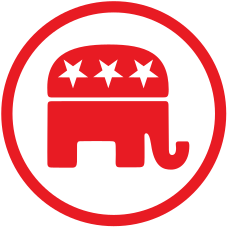

In [44]:
from IPython.display import Image, display
res = clipRetriever.retrieve("What's the republican party logo?", result_type="img", k = 1)
for img in res:
  abs_img_path = os.path.join("final_dataset_images", img["path"])
  display(Image(filename=abs_img_path))

In [47]:
hybridRetriever = HybridNumpySearch(hybrid_embedder, dataset)

Computing Embeddings for: <__main__.MMQAKnowledgeBase object at 0x7808ef907670>
Computing text embeddings


10it [00:03,  2.62it/s]


Computing image embeddings


10it [00:00, 5384.22it/s]

Storing embeddings


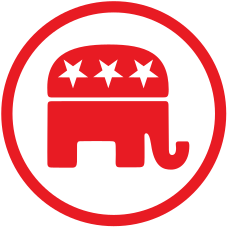







**********Get closest text document**********
[{'title': 'Hillaryland', 'url': 'https://en.wikipedia.org/wiki/Hillaryland', 'id': 'a7d9e6350bafc46b700e4d0739a39594', 'text': 'Hillaryland was the self-designated name of a group of core advisors to Hillary Clinton, when she was First Lady of the United States and again when, as United States Senator, she was one of the Democratic Party candidates for President in the 2008 U.S. election.', 'type': 'text'}]


In [52]:
from IPython.display import Image, display
res = clipRetriever.retrieve("What's the republican party logo?", result_type="img", k = 1)
for img in res:
  abs_img_path = os.path.join("final_dataset_images", img["path"])
  display(Image(filename=abs_img_path))

print("\n" * 5)
print("*" * 10 + "Get closest text document" + "*"*10)
print(clipRetriever.retrieve("What's the republican party logo?", result_type="text", k = 1))

# Conclusion
Voila, we see the magic of multimodal retrieval! You can index the complete dataset by removing the slice params in the dataloader. Feel free to explore and play around by making a copy of this notebook.

I demonstrated one way to iterate over a multimodal retrieval augmented generation concept. You can look at the [Github Repo](https://github.com/sugam11/rag-multimodal-qa/) for a detailed Multimodal Question Answering setup!